### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import necessary libraries

In [2]:
!pip install segmentation_models_pytorch
import os
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix
from functools import partial
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

### Set up the device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Calculate mean and std of the dataset

In [4]:
def compute_mean_std(directory):
    pixel_num = 0  # store all pixel number in the dataset
    channel_sum = None
    channel_sum_squared = None

    # Helper function to process each npy file
    def process_image(img_path):
        nonlocal pixel_num, channel_sum, channel_sum_squared
        img = np.load(img_path)  # Load npy file as a numpy array

        if img is None:
            print(f"Warning: Unable to read image '{img_path}'. It will be skipped.")
            return

        if channel_sum is None:
            # Initialize sum arrays with the shape of the image channels
            channel_sum = np.zeros(img.shape[2])
            channel_sum_squared = np.zeros(img.shape[2])

        pixel_num += (img.shape[0] * img.shape[1])  # Total number of pixels

        channel_sum += np.sum(img, axis=(0, 1))
        channel_sum_squared += np.sum(np.square(img, dtype=np.float64), axis=(0, 1))  # Use float64 to avoid overflow

    # Recursive function to walk through directory tree
    def recurse_folder(folder):
        for entry in os.listdir(folder):
            path = os.path.join(folder, entry)
            if os.path.isdir(path):
                recurse_folder(path)  # Recurse into subdirectories
            elif path.endswith('.npy'):
                process_image(path)  # Process this npy file

    # Start recursion
    recurse_folder(directory)

    # Compute mean and standard deviation
    mean = channel_sum / pixel_num
    variance = channel_sum_squared / pixel_num - np.square(mean)
    print("Variance before sqrt: ", variance)  # Check if variance has negative values
    std = np.sqrt(variance.clip(min=0))  # Clip negative values to zero before square root

    return mean, std

# Use the path to your dataset
mean, std = compute_mean_std('/content/drive/MyDrive/irp/dataset/dataset_combined-2/train/images')
print("Mean: ", mean)
print("Standard Deviation: ", std)

Variance before sqrt:  [1238.58105554 1866.79418141 1912.33707575 2528.22492084 3911.65051115
 2749.19274001]
Mean:  [ 43.8955462   71.56016493  86.46579829  40.91682513 166.04958509
  90.27916253]
Standard Deviation:  [35.1934803  43.20641366 43.73027642 50.28145703 62.54318917 52.43274492]


### Dataset class

In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, img_size, color_to_label, mean, std, augmentations=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.img_size = img_size
        self.color_to_label = color_to_label
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))
        self.augmentations = augmentations
        self.mean = torch.tensor(mean).view(6, 1, 1)
        self.std = torch.tensor(std).view(6, 1, 1)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx].replace('.npy', '.png'))

        image = np.load(img_path)

        mask = Image.open(mask_path)
        mask = np.array(mask)

        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))
        image = torch.from_numpy(image).float() 
        mask = torch.from_numpy(mask).long()

        center_crop = transforms.CenterCrop((116,116))
        image = center_crop(image)
        mask = center_crop(mask)

        resize = transforms.Resize(self.img_size)
        image = resize(image)
        mask = resize(mask)

        if image.shape[0] == 6:
            image = (image - self.mean) / self.std
        else:
            raise ValueError(f"Expected image with 6 channels, but got {image.shape[0]} channels")

        mask = self.mask_to_label(mask.numpy())

        return image, mask

    def mask_to_label(self, mask):
        mask = np.transpose(mask, (1, 2, 0))
        label_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
        for color, label in self.color_to_label.items():
            matches = np.all(mask == color, axis=-1)
            label_mask[matches] = label
        return torch.from_numpy(label_mask).long()

def get_aug():
    return Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        Rotate(limit=15, p=0.5)
    ], is_check_shapes=False)

### Load dataset

In [6]:
color_to_label = {
    (0, 0, 0): 0,    # background - black
    (255, 0, 0): 1,  # harbor - red
    (0, 255, 0): 2,  # jetty - green
    (0, 0, 255): 3   # resort - blue
}

In [7]:
train_dataset = SegmentationDataset(
    images_dir='/content/drive/MyDrive/irp/dataset/dataset_combined-2/train/images',
    masks_dir='/content/drive/MyDrive/irp/dataset/dataset_combined-2/train/masks',
    img_size=(128, 128),
    color_to_label=color_to_label,
    mean=mean,
    std=std,
    augmentations=get_aug()
)

val_dataset = SegmentationDataset(
    images_dir='/content/drive/MyDrive/irp/dataset/dataset_combined-2/val/images',
    masks_dir='/content/drive/MyDrive/irp/dataset/dataset_combined-2/val/masks',
    img_size=(128, 128),
    color_to_label=color_to_label,
    mean=mean,
    std=std,
)

test_dataset = SegmentationDataset(
    images_dir='/content/drive/MyDrive/irp/dataset/dataset_combined-2/test/images',
    masks_dir='/content/drive/MyDrive/irp/dataset/dataset_combined-2/test/masks',
    img_size=(128, 128),
    color_to_label=color_to_label,
    mean=mean,
    std=std,
)

augment_multiplier = 5

# Augment and sample the training set
train_sampler = RandomSampler(train_dataset, replacement=True, num_samples=len(train_dataset) * augment_multiplier)
train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=16, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Define the model

In [8]:
class UnetResnet34WithDropout(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(UnetResnet34WithDropout, self).__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=6,
            classes=4,
            decoder_attention_type="scse"
        )
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        # Get encoder features and apply dropout
        encoder_features = self.model.encoder(x)
        encoder_features = [self.dropout(f) for f in encoder_features]

        # Decode using the encoder features
        x = self.model.decoder(*encoder_features)
        x = self.dropout(x)

        # Apply dropout to the final output
        x = self.model.segmentation_head(x)
        x = self.dropout(x)

        return x

# Initialize model with dropout and move to device
model = UnetResnet34WithDropout(dropout_p=0.5)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 124MB/s]


### Model training

In [9]:
def calculate_recall(outputs, targets):

    device = targets.device

    # Ensure the output is a probability distribution, using softmax
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(outputs)

    # Get the prediction results from the probability
    preds = torch.argmax(probabilities, dim=1)

    recalls = []
    for c in range(4):  
        # True Positives (TP): Correct positive class predictions
        true_positive = ((preds == c) & (targets == c)).to(device)

        # False Negatives (FN): The actual label is positive, but the prediction is negative
        false_negative = ((preds != c) & (targets == c)).to(device)

        # Calculating recall
        TP = true_positive.sum().float().to(device)
        FN = false_negative.sum().float().to(device)

        if TP + FN == 0:
            recall = torch.tensor(0., device=device)
        else:
            recall = TP / (TP + FN)

        recalls.append(recall)

    # Convert a list to a tensor
    recalls = torch.stack(recalls).to(device)
    return recalls

def calculate_miou(preds, labels, num_classes=4):
    
    # Convert the prediction results into class predictions
    preds = torch.argmax(preds, dim=1)

    # Initialize the confusion matrix
    iou_per_class = []

    for cls in range(num_classes):
        pred_mask = (preds == cls)
        label_mask = (labels == cls)

        intersection = (pred_mask & label_mask).sum().item()
        union = (pred_mask | label_mask).sum().item()

        if union == 0:
            iou = float('nan')  
        else:
            iou = intersection / union

        iou_per_class.append(iou)

    # Calculate the average IoU of all categories
    mean_iou = torch.tensor([iou for iou in iou_per_class if not torch.isnan(torch.tensor(iou))]).mean().item()

    return mean_iou

In [10]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0, cls_weights=None):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.cls_weights = cls_weights

    def forward(self, inputs, targets):
        # Apply softmax to get probabilities
        inputs = torch.softmax(inputs, dim=1)

        dice_loss = 0.0
        num_classes = inputs.shape[1]

        for c in range(num_classes):
            input_flat = inputs[:, c].contiguous().view(-1)
            target_flat = (targets == c).float().contiguous().view(-1)

            intersection = torch.sum(input_flat * target_flat)
            union = torch.sum(input_flat) + torch.sum(target_flat)

            dice_score = (2. * intersection + self.smooth) / (union + self.smooth)

            # Apply class weight if provided
            if self.cls_weights is not None:
                dice_class_loss = (1 - dice_score) * self.cls_weights[c]
            else:
                dice_class_loss = 1 - dice_score

            dice_loss += dice_class_loss

        return dice_loss / num_classes

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.4, gamma=2.0, cls_weights=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.cls_weights = cls_weights

    def forward(self, inputs, targets):
        # Apply softmax to get probabilities
        inputs = torch.softmax(inputs, dim=1)

        focal_loss = 0.0
        num_classes = inputs.shape[1]

        for c in range(num_classes):
            input_flat = inputs[:, c].contiguous().view(-1)
            target_flat = (targets == c).float().contiguous().view(-1)

            # Compute the focal loss components
            logpt = torch.log(input_flat + 1e-6)  # Add a small epsilon to prevent log(0)
            pt = torch.exp(logpt)

            # Apply focal loss formula
            if self.cls_weights is not None:
                logpt = logpt * self.cls_weights[c]

            focal_loss += -((1 - pt) ** self.gamma) * logpt * target_flat

        if self.alpha is not None:
            focal_loss *= self.alpha

        return focal_loss.mean()


In [11]:
class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.5, weight_focal=0.5, dice_smooth=1.0,
                 focal_alpha=0.4, focal_gamma=2.0, cls_weights=None,
                 use_dice_weight=True, use_focal_weight=True, use_focal=True):
        super(CombinedLoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_focal = weight_focal
        self.use_focal = use_focal

        # Initialize Dice Loss with or without class weights
        dice_cls_weights = cls_weights if use_dice_weight else None
        self.dice_loss = DiceLoss(smooth=dice_smooth,
                                          cls_weights=dice_cls_weights)

        # Initialize Focal Loss or CrossEntropyLoss with or without class weights
        if self.use_focal:
            focal_cls_weights = cls_weights if use_focal_weight else None
            self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma,
                                        cls_weights=focal_cls_weights)
        else:
            ce_cls_weights = cls_weights if use_focal_weight else None
            self.ce_loss = nn.CrossEntropyLoss(weight=ce_cls_weights)

    def forward(self, inputs, targets):
        # Calculate Dice Loss
        dice_loss = self.dice_loss(inputs, targets)

        # Calculate Focal Loss or CrossEntropyLoss based on use_focal flag
        if self.use_focal:
            focal_loss = self.focal_loss(inputs, targets)
            return self.weight_dice * dice_loss + self.weight_focal * focal_loss
        else:
            ce_loss = self.ce_loss(inputs, targets)
            return self.weight_dice * dice_loss + self.weight_focal * ce_loss

In [12]:
class_counts = [15878233, 239011, 29359, 106325]
total_count = sum(class_counts)
cls_weights = [total_count / count for count in class_counts]
cls_weights = torch.tensor(cls_weights, dtype=torch.float32).to(device)

In [13]:
criterion = CombinedLoss(weight_dice=0.5, weight_focal=0.5,
                         cls_weights=cls_weights,
                         use_dice_weight=False, use_focal_weight=False,
                         use_focal=True)

# Initialize learning rate and minimum learning rate
Init_lr = 1e-4
Min_lr = Init_lr * 0.01
nbs = 16  

# Adaptively adjust the learning rate according to the current batch_size
def adjust_learning_rate(batch_size, Init_lr, Min_lr, lr_limit_min=3e-4, lr_limit_max=5e-4):
    Init_lr_fit = min(max(batch_size / nbs * Init_lr, lr_limit_min), lr_limit_max)
    Min_lr_fit = min(max(batch_size / nbs * Min_lr, lr_limit_min * 1e-2), lr_limit_max * 1e-2)
    return Init_lr_fit, Min_lr_fit

# Initial batch_size and learning rate adjustment
batch_size = 16
Init_lr_fit, Min_lr_fit = adjust_learning_rate(batch_size, Init_lr, Min_lr)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=Init_lr_fit, weight_decay=5e-4)

def cosine_lr_scheduler(lr, min_lr, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter, iters):
    if iters <= warmup_total_iters:
        lr = (lr - warmup_lr_start) * pow(iters / float(warmup_total_iters), 2) + warmup_lr_start
    elif iters >= total_iters - no_aug_iter:
        lr = min_lr
    else:
        lr = min_lr + 0.5 * (lr - min_lr) * (
            1.0 + math.cos(math.pi * (iters - warmup_total_iters) / (total_iters - warmup_total_iters - no_aug_iter))
        )
    return lr

total_iters = 120
warmup_total_iters = min(max(0.1 * total_iters, 1), 3)
warmup_lr_start = max(0.1 * Init_lr_fit, 1e-6)
no_aug_iter = min(max(0.3 * total_iters, 1), 15)

# Initial definition of lr_scheduler_func
lr_scheduler_func = partial(cosine_lr_scheduler, Init_lr_fit, Min_lr_fit, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter)

def set_optimizer_lr(optimizer, lr_scheduler_func, epoch):
    lr = lr_scheduler_func(epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def set_freeze_by_stage(model, stage):
    if stage == 1:
        for name, param in model.model.encoder.named_parameters():
            if "layer1" in name or "layer2" in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
    elif stage == 2:
        for name, param in model.model.encoder.named_parameters():
            if "layer1" in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
    else:
        for param in model.model.encoder.parameters():
            param.requires_grad = True

In [14]:
def train_model(model, train_loader, val_loader, device, num_epochs=120, save_path='best_model.pth'):
    train_losses = []
    val_losses = []
    train_mious = []
    val_mious = []
    val_recalls = []

    stage = 1  
    batch_size = 16  
    best_val_miou = 0.0 

    # Initialize the learning rate adjustment function
    Init_lr_fit, Min_lr_fit = adjust_learning_rate(batch_size, Init_lr, Min_lr)
    lr_scheduler_func = partial(cosine_lr_scheduler, Init_lr_fit, Min_lr_fit, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter)

    for epoch in range(num_epochs):
        if epoch == 40: 
            stage = 2
            set_freeze_by_stage(model, stage)
            batch_size = 8  
            Init_lr_fit, Min_lr_fit = adjust_learning_rate(batch_size, Init_lr, Min_lr)
            lr_scheduler_func = partial(cosine_lr_scheduler, Init_lr_fit, Min_lr_fit, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter)
        elif epoch == 80:
            stage = 3
            set_freeze_by_stage(model, stage)
            batch_size = 4 
            Init_lr_fit, Min_lr_fit = adjust_learning_rate(batch_size, Init_lr, Min_lr)
            lr_scheduler_func = partial(cosine_lr_scheduler, Init_lr_fit, Min_lr_fit, total_iters, warmup_total_iters, warmup_lr_start, no_aug_iter)

        # Update the optimizer's learning rate
        set_optimizer_lr(optimizer, lr_scheduler_func, epoch)

        model.train()
        total_train_loss = 0
        total_train_miou = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            miou = calculate_miou(outputs, targets)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_miou += miou

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_miou = total_train_miou / len(train_loader)
        train_losses.append(avg_train_loss)
        train_mious.append(avg_train_miou)

        model.eval()
        total_val_loss = 0
        total_val_miou = 0
        total_val_recall = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, targets)
                miou = calculate_miou(outputs, targets)
                recall = calculate_recall(outputs, targets)

                total_val_loss += loss.item()
                total_val_miou += miou
                total_val_recall += recall.mean().item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_miou = total_val_miou / len(val_loader)
        avg_val_recall = total_val_recall / len(val_loader)
        val_losses.append(avg_val_loss)
        val_mious.append(avg_val_miou)
        val_recalls.append(avg_val_recall)

        # Check and save the best model
        if avg_val_miou > best_val_miou:
            best_val_miou = avg_val_miou
            torch.save(model.state_dict(), '/content/drive/MyDrive/irp/final_model/Unet-Resnet34-correct.pth')
            print(f'Saved best model with mIoU: {best_val_miou:.4f}')

        print(f'Epoch {epoch+1}/{num_epochs}, LR: {optimizer.param_groups[0]["lr"]:.6f}, '
              f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
              f'Train mIoU: {avg_train_miou:.4f}, Val mIoU: {avg_val_miou:.4f}, '
              f'Val Recall: {avg_val_recall:.4f}')

    return train_losses, val_losses, train_mious, val_mious, val_recalls


Saved best model with mIoU: 0.0141
Epoch 1/120, LR: 0.000030, Train Loss: 0.7644, Val Loss: 0.6588, Train mIoU: 0.0697, Val mIoU: 0.0141, Val Recall: 0.2536
Saved best model with mIoU: 0.1967
Epoch 2/120, LR: 0.000060, Train Loss: 0.6410, Val Loss: 0.5980, Train mIoU: 0.0994, Val mIoU: 0.1967, Val Recall: 0.2474
Saved best model with mIoU: 0.2131
Epoch 3/120, LR: 0.000150, Train Loss: 0.6005, Val Loss: 0.5790, Train mIoU: 0.1322, Val mIoU: 0.2131, Val Recall: 0.2374
Saved best model with mIoU: 0.2351
Epoch 4/120, LR: 0.000300, Train Loss: 0.5523, Val Loss: 0.5312, Train mIoU: 0.1722, Val mIoU: 0.2351, Val Recall: 0.2420
Saved best model with mIoU: 0.2413
Epoch 5/120, LR: 0.000300, Train Loss: 0.5025, Val Loss: 0.4594, Train mIoU: 0.2163, Val mIoU: 0.2413, Val Recall: 0.2470
Saved best model with mIoU: 0.2438
Epoch 6/120, LR: 0.000300, Train Loss: 0.4696, Val Loss: 0.4049, Train mIoU: 0.2379, Val mIoU: 0.2438, Val Recall: 0.2494
Saved best model with mIoU: 0.2474
Epoch 7/120, LR: 0.0002

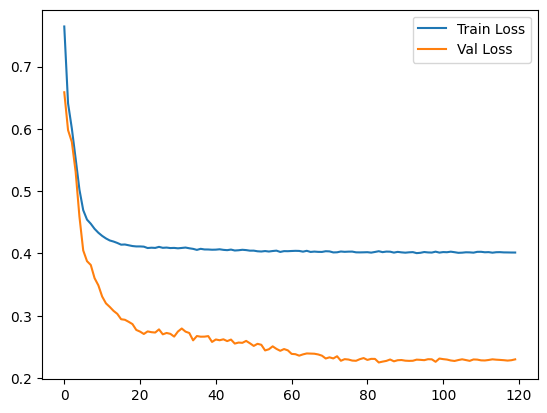

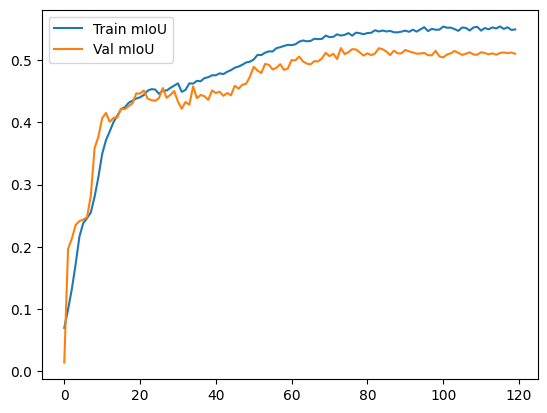

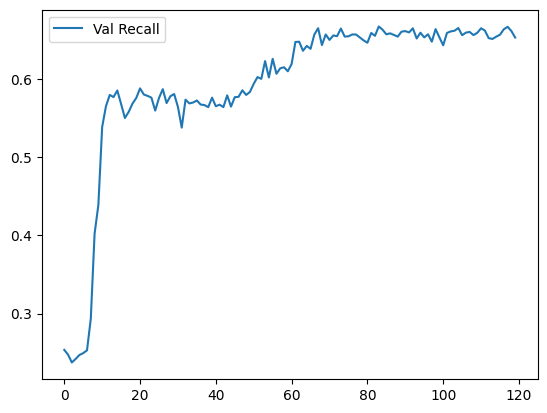

In [15]:
# Training the model
train_losses, val_losses, train_mious, val_mious, val_recalls = train_model(model, train_loader, val_loader, device)

# Plotting the training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

# Plotting the training and validation mIoU
plt.plot(train_mious, label='Train mIoU')
plt.plot(val_mious, label='Val mIoU')
plt.legend()
plt.show()

# Plotting the validation recall
plt.plot(val_recalls, label='Val Recall')
plt.legend()
plt.show()

### Model test

In [16]:
class UnetResnet34WithDropout(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(UnetResnet34WithDropout, self).__init__()
        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights=None,
            in_channels=6,
            classes=4,
            decoder_attention_type="scse"
        )
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        # Get encoder features and apply dropout
        encoder_features = self.model.encoder(x)
        encoder_features = [self.dropout(f) for f in encoder_features]

        # Decode using the encoder features
        x = self.model.decoder(*encoder_features)
        x = self.dropout(x)

        # Apply dropout to the final output
        x = self.model.segmentation_head(x)
        x = self.dropout(x)

        return x


In [17]:
model = UnetResnet34WithDropout(dropout_p=0.5)
model.load_state_dict(torch.load('/content/drive/MyDrive/irp/final_model/Unet-Resnet34-correct.pth'))
model = model.to(device)
model.eval()

UnetResnet34WithDropout(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [18]:
def evaluate_model(model, test_loader, num_classes, device):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # Initialize accumulators for various metrics
    iou_per_class = []
    dice_per_class = []
    precision_per_class = []
    recall_per_class = []
    f1_per_class = []
    confusion_mat = torch.zeros(num_classes, num_classes)

    for cls in range(num_classes):
        pred_cls = all_preds == cls
        target_cls = all_targets == cls

        intersection = (pred_cls & target_cls).float().sum()
        union = (pred_cls | target_cls).float().sum()

        iou = (intersection + 1e-6) / (union + 1e-6)
        iou_per_class.append(iou)

        dice = (2 * intersection + 1e-6) / (pred_cls.float().sum() + target_cls.float().sum() + 1e-6)
        dice_per_class.append(dice)

        precision = (intersection + 1e-6) / (pred_cls.float().sum() + 1e-6)
        recall = (intersection + 1e-6) / (target_cls.float().sum() + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        precision_per_class.append(precision)
        recall_per_class.append(recall)
        f1_per_class.append(f1)

        # Print IoU for the current class
        print(f'Class {cls}: IoU = {iou:.4f}, Dice = {dice:.4f}, Precision = {precision:.4f}, '
              f'Recall = {recall:.4f}, F1 Score = {f1:.4f}')

    # Calculate the mean metrics across all classes
    mean_iou = sum(iou_per_class) / num_classes
    mean_dice = sum(dice_per_class) / num_classes
    mean_precision = sum(precision_per_class) / num_classes
    mean_recall = sum(recall_per_class) / num_classes
    mean_f1 = sum(f1_per_class) / num_classes

    correct = (all_preds == all_targets).float().sum()
    accuracy = correct / all_targets.numel()

    confusion_mat += confusion_matrix(
        all_targets.view(-1), all_preds.view(-1),
        labels=list(range(num_classes))
    )

    class_accuracies = confusion_mat.diag() / confusion_mat.sum(1)
    balanced_accuracy = class_accuracies.mean().item()

    print(f'\nTest Mean IoU: {mean_iou:.4f}, Test Accuracy: {accuracy:.4f}, '
          f'Test Mean Dice: {mean_dice:.4f}')
    print(f'Test Mean Precision: {mean_precision:.4f}, Test Mean Recall: {mean_recall:.4f}, '
          f'Test Mean F1 Score: {mean_f1:.4f}')
    print(f'Balanced Accuracy: {balanced_accuracy:.4f}')

    return {
        'iou': mean_iou.item(),
        'accuracy': accuracy.item(),
        'dice': mean_dice.item(),
        'precision': mean_precision.item(),
        'recall': mean_recall.item(),
        'f1': mean_f1.item(),
        'balanced_accuracy': balanced_accuracy,
        'confusion_matrix': confusion_mat
    }

In [19]:
# Evaluating the model on the test dataset
evaluate_model(model, test_loader, 4, device)

Class 0: IoU = 0.9913, Dice = 0.9956, Precision = 0.9969, Recall = 0.9944, F1 Score = 0.9956
Class 1: IoU = 0.6373, Dice = 0.7785, Precision = 0.7429, Recall = 0.8176, F1 Score = 0.7785
Class 2: IoU = 0.2185, Dice = 0.3586, Precision = 0.2839, Recall = 0.4864, F1 Score = 0.3586
Class 3: IoU = 0.5941, Dice = 0.7454, Precision = 0.6966, Recall = 0.8015, F1 Score = 0.7454

Test Mean IoU: 0.6103, Test Accuracy: 0.9912, Test Mean Dice: 0.7195
Test Mean Precision: 0.6801, Test Mean Recall: 0.7750, Test Mean F1 Score: 0.7195
Balanced Accuracy: 0.7750


{'iou': 0.610298752784729,
 'accuracy': 0.9911656975746155,
 'dice': 0.7195193767547607,
 'precision': 0.6801148653030396,
 'recall': 0.7749578356742859,
 'f1': 0.7195188999176025,
 'balanced_accuracy': 0.7749577988082695,
 'confusion_matrix': tensor([[4.3314e+05, 9.8400e+02, 5.6500e+02, 9.1000e+02],
         [6.1400e+02, 2.8640e+03, 2.5000e+01, 0.0000e+00],
         [2.1000e+02, 7.0000e+00, 2.5100e+02, 4.8000e+01],
         [5.0200e+02, 0.0000e+00, 4.3000e+01, 2.2000e+03]], dtype=torch.float64)}

In [20]:
def label_to_color(label_mask, color_map):
    color_mask = np.zeros((label_mask.shape[0], label_mask.shape[1], 3), dtype=np.uint8)
    for key, value in color_map.items():
        color_mask[label_mask == value] = np.array(key)
    return color_mask

color_to_label = {
    (0, 0, 0): 0,    # background - black
    (255, 0, 0): 1,  # harbor - red
    (0, 255, 0): 2,  # jetty - green
    (0, 0, 255): 3   # resort - blue
}

In [21]:
def denormalize_image(img, mean, std):
    mean = np.array(mean).reshape(1, 1, -1)  
    std = np.array(std).reshape(1, 1, -1)
    img_denormalized = img * std + mean
    img_denormalized = np.clip(img_denormalized, 0, 255)  
    return img_denormalized

In [22]:
def show_predictions(model, test_loader, device, color_map, mean, std, num_images=27):
    model.eval()
    images_handled = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            if images_handled >= num_images:
                break

            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            # convert the shape of inputs, targets, and preds to (B, H, W, C)
            inputs = inputs.cpu().numpy().transpose(0, 2, 3, 1)
            targets = targets.cpu().numpy()
            preds = preds.cpu().numpy()

            for i in range(inputs.shape[0]):
                if images_handled >= num_images:
                    break

                plt.figure(figsize=(10, 6))

                # denormalize the image
                original_img = denormalize_image(inputs[i], mean, std)

                # choose the first 3 channels if the image has more than 3 channels
                if original_img.shape[-1] >= 3:
                    original_img_rgb = original_img[:, :, :3]  
                else:
                    original_img_rgb = original_img  

                print(f"Image min: {original_img_rgb.min()}, max: {original_img_rgb.max()}")

                plt.subplot(1, 3, 1)
                plt.imshow(np.clip(original_img_rgb / 255.0, 0, 1))
                plt.title('Original Image')
                plt.axis('off')

                # show the true mask
                true_color_mask = label_to_color(targets[i], color_map)
                plt.subplot(1, 3, 2)
                plt.imshow(true_color_mask)
                plt.title('True Mask')
                plt.axis('off')

                # show the predicted mask
                pred_color_mask = label_to_color(preds[i], color_map)
                plt.subplot(1, 3, 3)
                plt.imshow(pred_color_mask)
                plt.title('Predicted Mask')
                plt.axis('off')

                plt.show()
                images_handled += 1


Image min: 9.944406826889463e-07, max: 245.98096221543574


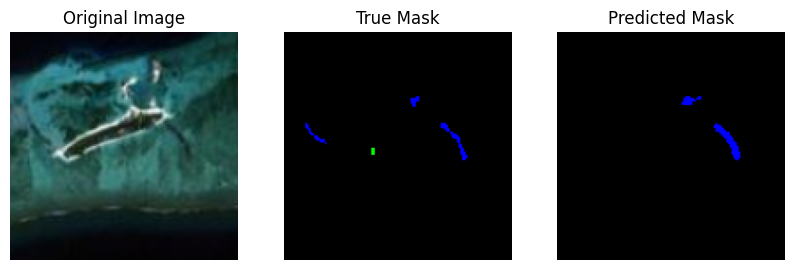

Image min: 19.823729557785285, max: 252.12378080799567


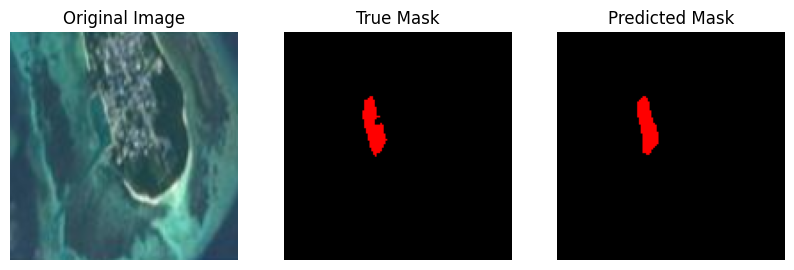

Image min: 33.09643563816499, max: 255.0


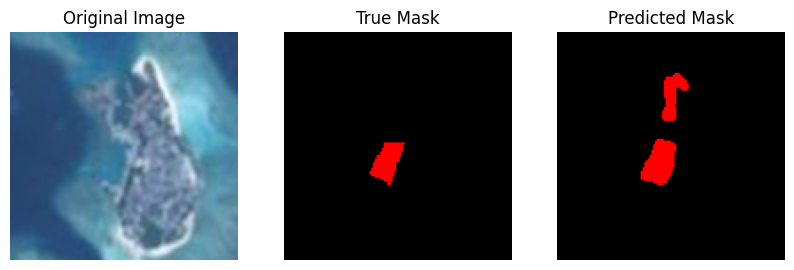

Image min: 21.344971600102053, max: 252.43041641400234


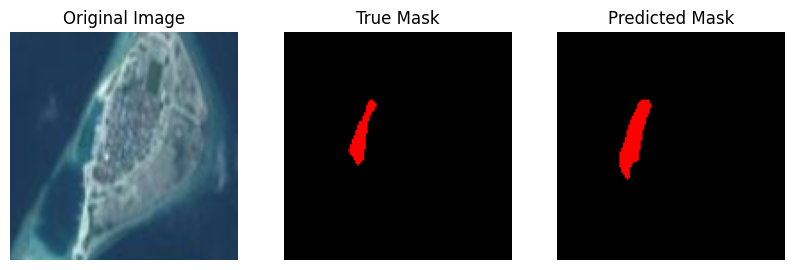

Image min: 6.400742904588697e-07, max: 195.64574820949406


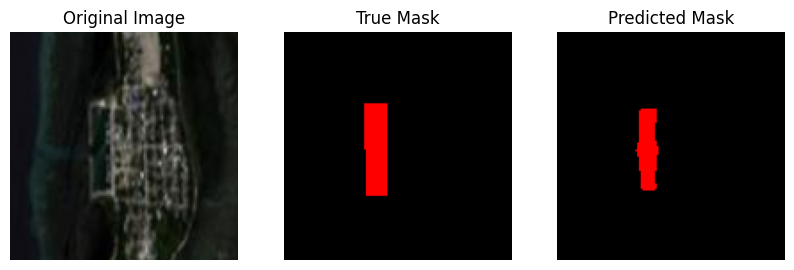

Image min: 14.796874352663526, max: 255.0


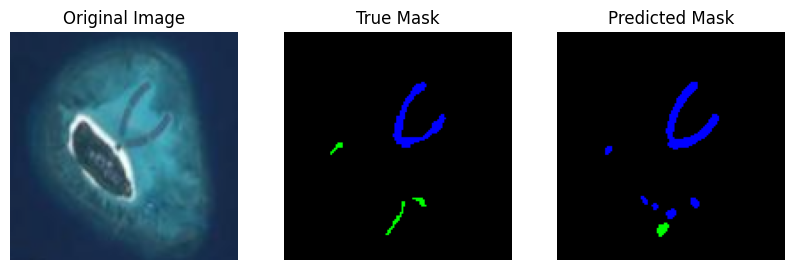

Image min: 16.796875397789186, max: 247.91308514886595


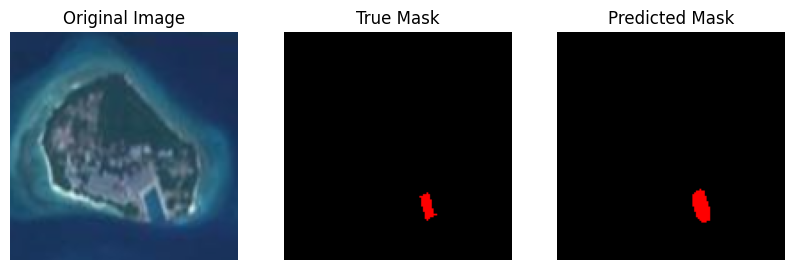

Image min: 26.586426236873574, max: 254.85961672080032


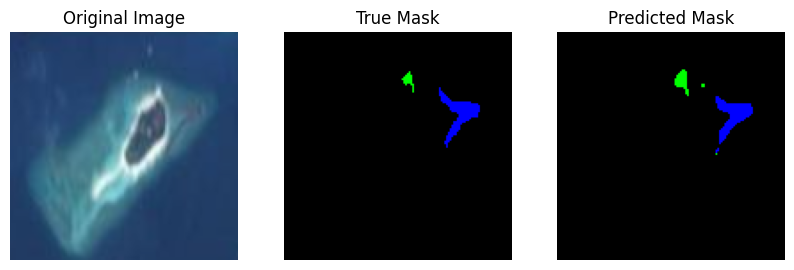

Image min: 19.41235271028495, max: 233.6406262748259


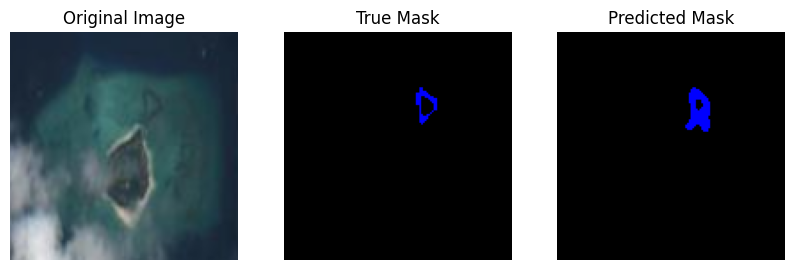

Image min: 6.400742904588697e-07, max: 255.0


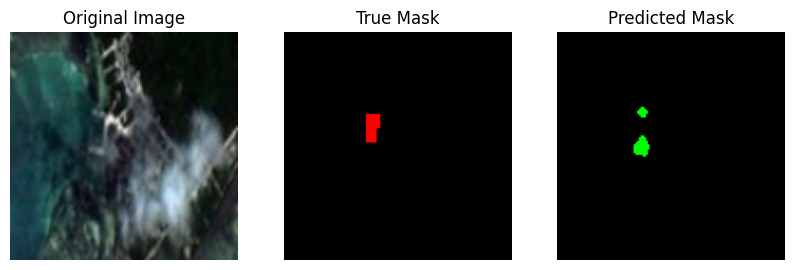

Image min: 15.537597688927466, max: 254.8779333847062


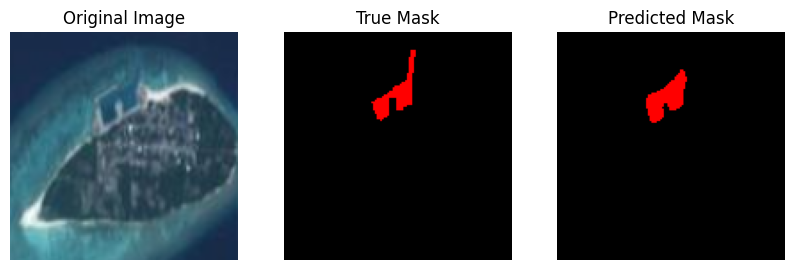

Image min: 13.43652341083897, max: 251.69922286780314


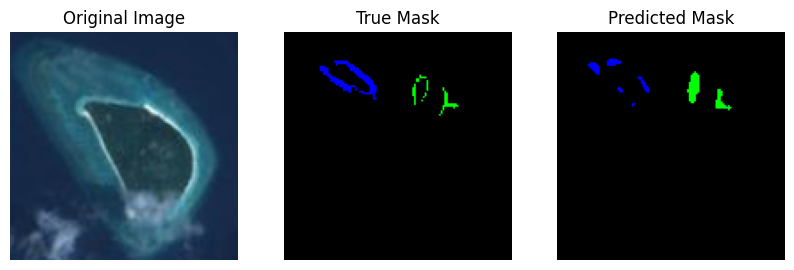

Image min: 6.400742904588697e-07, max: 254.65625130778125


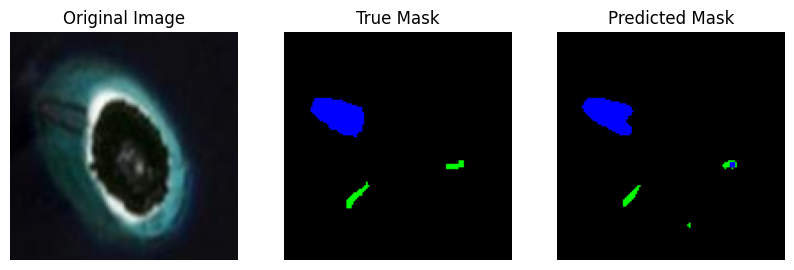

Image min: 6.400742904588697e-07, max: 254.2749004486845


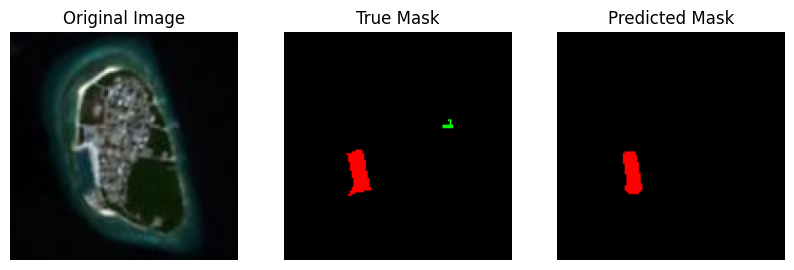

Image min: 18.0480958605722, max: 254.8461878906467


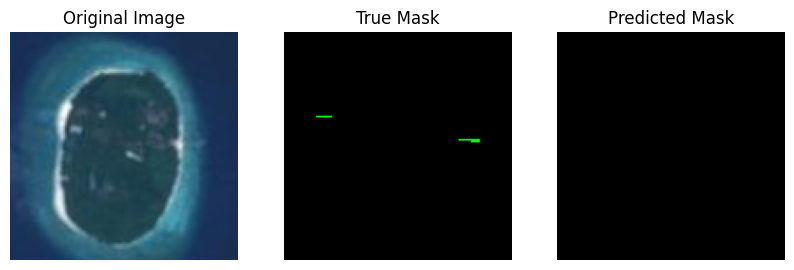

Image min: 11.657470470952553, max: 254.69922143890318


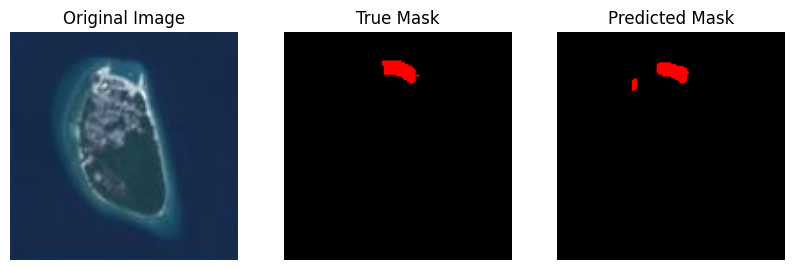

Image min: 12.724364385914193, max: 251.90063901156464


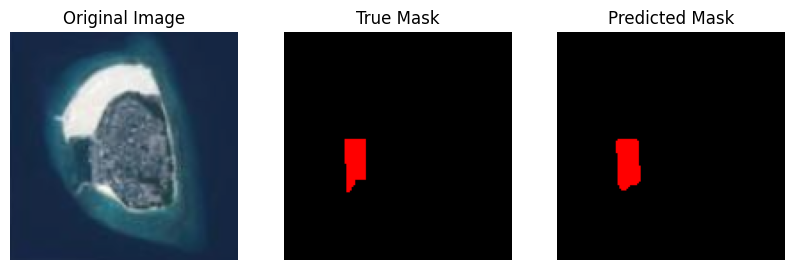

Image min: 17.687500011008158, max: 254.8461878906467


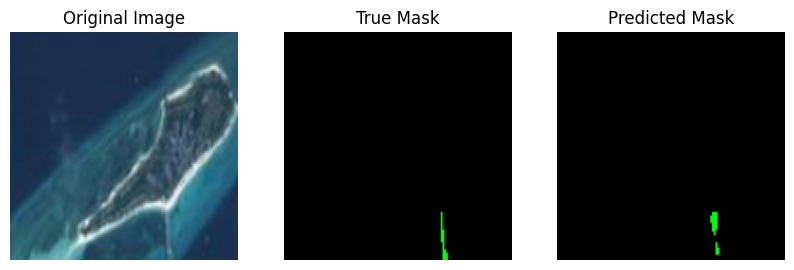

Image min: 27.640624902351142, max: 237.15917787117533


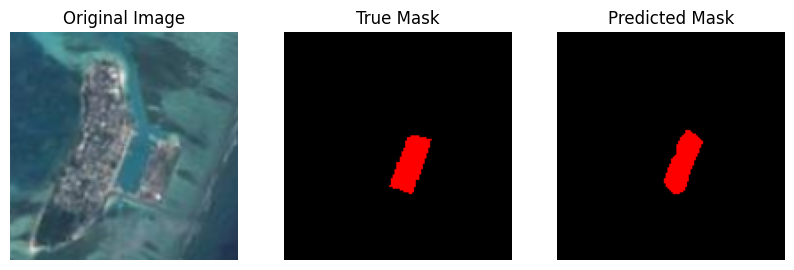

Image min: 11.69750917334887, max: 249.76000295187757


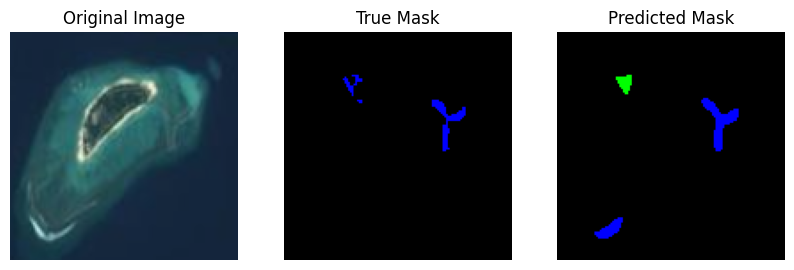

Image min: 8.191650580241564, max: 254.722409108361


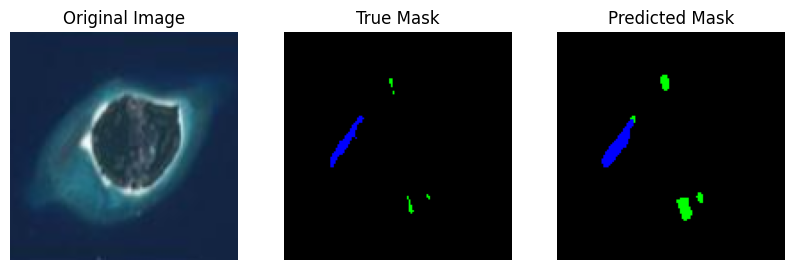

Image min: 10.40844629472106, max: 252.79589367003314


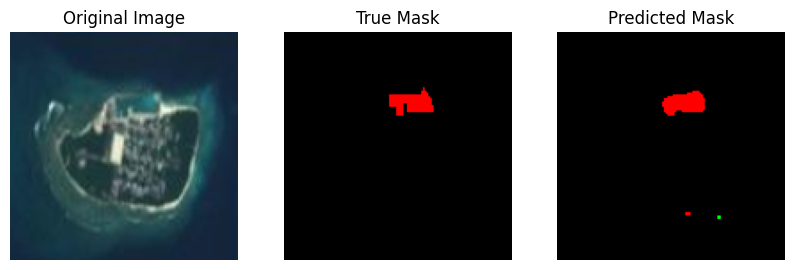

Image min: 7.503661195858008, max: 255.0


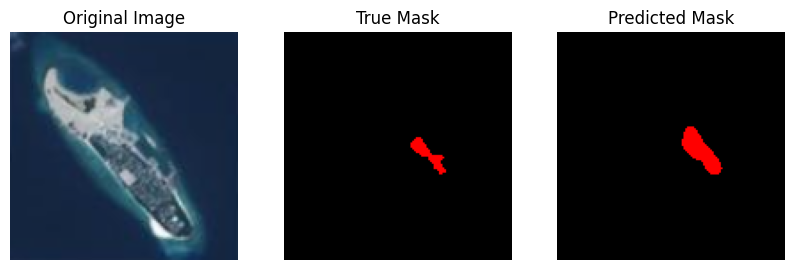

Image min: 21.124512257772558, max: 254.74487737620345


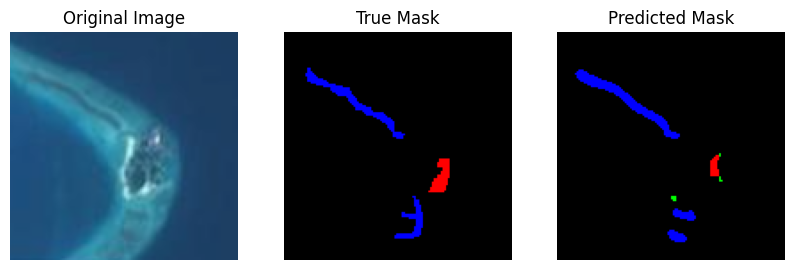

Image min: 17.99999991209718, max: 255.0


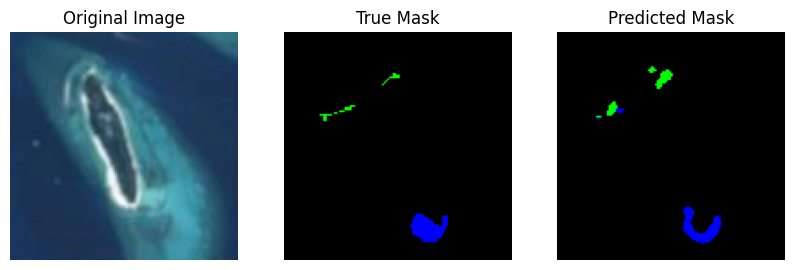

Image min: 24.781981749171564, max: 254.54711491474836


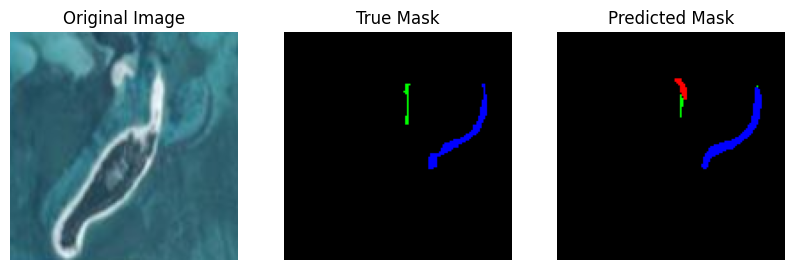

Image min: 13.628418441829304, max: 255.0


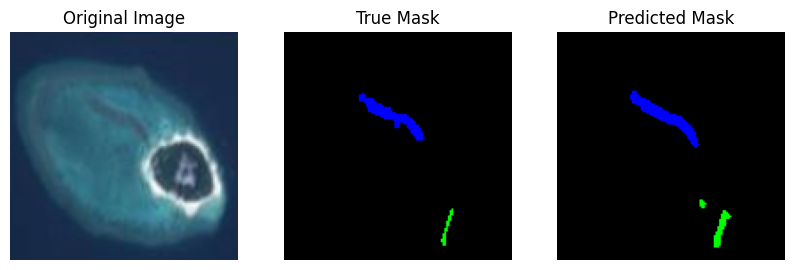

In [23]:
show_predictions(model, test_loader, device, color_to_label, mean, std)